In [17]:
from functools import partial
from collections import ChainMap
from typing import TypedDict

import numpy as np
import PIL
import matplotlib.pyplot as plt
import trimesh
from trimesh import Scene

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:

mesh = trimesh.load("../models/bunny.ply")

# Normalize the mesh using trimesh functionality
mesh.apply_translation(-mesh.centroid)
scale_factor = 1.0 / mesh.extents.max()
mesh.apply_scale(scale_factor)


<trimesh.Trimesh(vertices.shape=(8146, 3), faces.shape=(16301, 3))>

In [3]:

def get_transformed_scene(mesh, rotation_transform, translation_vector) -> Scene:
    transformed = mesh.copy()
    transformed.apply_transform(rotation_transform)
    # transformed.apply_translation(translation_vector)
    # tt = transformed.apply_obb()  # i guess it works..
    scene = Scene()
    scene.add_geometry(transformed, geom_name="mesh") #, transform=transformation_matrix)
    scene.apply_translation(translation_vector)
    scene.camera.resolution = [640, 480]
    # set field of view, in degrees
    # make it relative to resolution so pixels per degree is same
    scene.camera.fov = [
        60,
        60,
    ]  # * (scene.camera.resolution / scene.camera.resolution.max())
    return scene

scene = get_transformed_scene(mesh, trimesh.transformations.euler_matrix(*[0, 0, 0]), [0, 0, 0])
origin, vectors, pixels = scene.camera_rays()


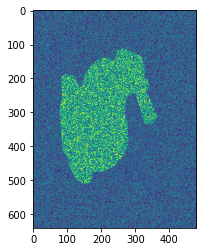

In [4]:

def raytrace_silhouette(scene, perc=0.5, inds=None):
    if perc == 1:
        origin = np.broadcast_to(trimesh.transformations.translation_from_matrix(scene.camera_transform), vectors.shape)
        hits = scene.geometry["mesh"].ray.intersects_any(ray_origins=origin, ray_directions=vectors)
        return hits.reshape(scene.camera.resolution)[:, ::-1].astype(np.uint8) + 1

    w, h = scene.camera.resolution
    if inds is None:
        inds = np.random.choice(w*h, int(w*h*perc), False)

    origin = np.broadcast_to(trimesh.transformations.translation_from_matrix(scene.camera_transform), (inds.shape[0], 3))
    # run the mesh- ray test
    hits = scene.geometry["mesh"].ray.intersects_any(ray_origins=origin, ray_directions=vectors[inds])

    # find pixel locations of actual hits
    sub_pixels = pixels[inds]
    pixel_ray = sub_pixels[hits]

    # create a numpy array we can turn into an image
    # doing it with uint8 creates an `L` mode greyscale image
    a = np.zeros(scene.camera.resolution, dtype=np.uint8)
    a[sub_pixels[:, 0], sub_pixels[:, 1]] = 1
    a[pixel_ray[:, 0], pixel_ray[:, 1]] = 2
    return a

sil = raytrace_silhouette(scene, perc=0.6)

plt.imshow(sil)

In [15]:
# %%timeit
sil = raytrace_silhouette(scene, perc=0.6)
# 50.6 ms ± 1.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

In [16]:
## jacaards index for comparing two incomplete masks:
def stochastic_jacaard_index(m1: np.ndarray, m2: np.ndarray):
    """Where 2 means positive, 1 means negative, and 0 means not measured/unknown, I / U should only consider knowns"""
    m1_pos = m1 == 2
    m2_pos = m2 == 2
    m1_neg = m1 == 1
    m2_neg = m2 == 1
    count_agree_pos = (m1_pos & m2_pos).sum()  # intersection
    count_pos = (m1_pos & m2_neg).sum() + (m1_neg & m2_pos).sum() + count_agree_pos
    if count_pos == 0:
        return 0
    return count_agree_pos / count_pos

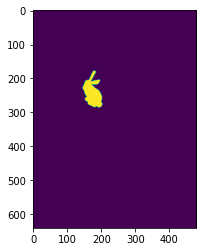

In [7]:
true_rotation = np.array([1, 0, 1])  # np.random.rand(3) * 2 * np.pi
true_translation = np.array([1, 1, 5])

scene = get_transformed_scene(mesh, trimesh.transformations.euler_matrix(*true_rotation), true_translation)
true_sil = raytrace_silhouette(scene, perc=1)

plt.imshow(true_sil == 2)

0.21604486710558402


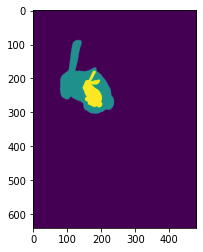

In [8]:

rotation = true_rotation + np.array([.6, .1, .2])
translation = true_translation + np.array([-.5, -.5, -4])

scene = get_transformed_scene(mesh, trimesh.transformations.euler_matrix(*rotation), translation)
sil = raytrace_silhouette(scene, perc=1)

print(stochastic_jacaard_index(true_sil, sil))
  
plt.imshow(sil + true_sil)

In [9]:
def get_scene_from_theta(theta: np.ndarray):
    # theta is rotation matrix, and translation matrix
    rotation = theta[:3]
    translation = theta[3:]
    rotation_matrix = trimesh.transformations.euler_matrix(*rotation)
    return get_transformed_scene(mesh, rotation_matrix, translation)

def get_loss_from_sil(sil):
    js = stochastic_jacaard_index(true_sil, sil)
    js = np.clip(js, 0.00001, 0.99999)
    log_odds = np.log(1 - js) - np.log(js)
    return log_odds

def get_loss_from_theta(theta: np.ndarray, perc=0.5, inds=None):
    scene = get_scene_from_theta(theta)
    sil = raytrace_silhouette(scene, perc=perc, inds=inds)
    return get_loss_from_sil(sil)

theta_0 = np.append(rotation, translation)
get_loss_from_theta(theta_0)


1.265367515393306

In [10]:
theta_opt = np.append(true_rotation, true_translation)
get_loss_from_theta(theta_opt)

-11.51291546492478

In [11]:
def ak_gain(k, a0=1e-2, A=1000, alpha=0.602):
    """Rule of thumb, A ~ <=10% max iterations expected
    a0 to be smallest of desired changes among theta early on"""
    a = a0 * (1 + A) ** alpha
    return a / (k + 1 + A) ** alpha


def ck_gain(k, c=1e-2, gamma=0.101):
    """Rule of thumb, c ~ std loss noise (e in y = L + e)"""
    return c / (k + 1) ** gamma


def bernouli_sample(p):
    while True:
        proba = np.random.rand(p)
        values = (proba < 0.5).astype(int) * 2 - 1
        yield values


def approx_gradient(loss, perturb, theta, c):
    # SPSA
    diff = loss(theta + c * perturb) - loss(theta - c * perturb)
    return (diff / (2 * c)) / perturb


def optim_spsa(theta_0, loss_fnc, ak_gen, ck_gen, max_theta_diff=0.1, num_approx=2):
    theta = theta_0
    P = len(theta)
    k = 0
    perturb_gen = bernouli_sample(P)
    while True:
        ak = ak_gen(k)
        ck = ck_gen(k)
        grads = []
        for i, perturb in zip(range(num_approx), perturb_gen):
            grad_i = approx_gradient(loss_fnc, perturb, theta, ck)
            grads.append(grad_i)
        grad = np.mean(grads, axis=0)
        assert grad.shape == theta.shape, grad.shape
        theta_diff = ak * grad
        theta_diff_mag = np.sqrt(theta_diff @ theta_diff)
        if theta_diff_mag > max_theta_diff:
            theta_diff *= max_theta_diff / theta_diff_mag
        theta = theta - theta_diff
        yield theta

optim = optim_spsa(np.array(theta_0), get_loss_from_theta, ak_gain, ck_gain)

In [12]:
for i, theta in zip(range(100), optim):
    if i % 10 == 0:
        print(f"{i}: {get_loss_from_theta(theta)}")

0: 1.2842240951988522
10: 1.0328356839255646
20: 0.9423791679584531
30: 0.8331244571226308
40: 0.7645371766466181
50: 0.7237018488819178
60: 0.6161745182057969
70: 0.48956676426439644
80: 0.4563123072760825
90: 0.3881294592975003


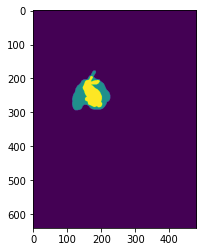

In [13]:
scene = get_scene_from_theta(theta)
sil = raytrace_silhouette(scene, perc=1)
plt.imshow(sil + true_sil)

In [14]:
fig, ax = plt.subplots()

theta = np.array(theta_0)
optim = optim_spsa(np.array(theta), get_loss_from_theta, ak_gain, ck_gain, num_approx=3)

scene = get_scene_from_theta(theta)
sil = raytrace_silhouette(scene, perc=1)

img = ax.imshow(sil + true_sil)
plt.close()
# This function updates the y-data of the line for each frame
def update(i):
    theta = next(optim)
    scene = get_scene_from_theta(theta)
    sil = raytrace_silhouette(scene, perc=1)
    if i % 10 == 0:
        print(f"{i}: {get_loss_from_sil(sil)}")
    
    img.set_data(sil + true_sil)
    return img

ani = FuncAnimation(fig, update, frames=range(50), blit=False, interval=100)
HTML(ani.to_jshtml())

0: 1.2457243892165126
0: 1.1941109876548195
10: 1.068052232894052
20: 0.9333009898271634
30: 0.8156781123256365
40: 0.6951377968862611
50: 0.627088902290958
60: 0.5408902817879426
70: 0.4792108926447432
80: 0.4258700509062546
90: 0.3511607872118264


KeyboardInterrupt: 

So let's just try translation... we need to update theta to just be translation

1.887702593829079

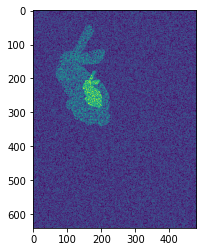

In [18]:
def get_scene_from_theta(theta: np.ndarray):
    # theta is rotation matrix, and translation matrix
    rotation = true_rotation
    translation = theta
    rotation_matrix = trimesh.transformations.euler_matrix(*rotation)
    return get_transformed_scene(mesh, rotation_matrix, translation)

def get_loss_from_sil(sil):
    js = stochastic_jacaard_index(true_sil, sil)
    js = np.clip(js, 0.00001, 0.99999)
    log_odds = np.log(1 - js) - np.log(js)
    return log_odds

def get_loss_from_theta(theta: np.ndarray, perc=0.5, inds=None):
    scene = get_scene_from_theta(theta)
    sil = raytrace_silhouette(scene, perc=perc, inds=inds)
    return get_loss_from_sil(sil)

theta_0 = np.array(translation)

scene = get_scene_from_theta(theta_0)
sil = raytrace_silhouette(scene, perc=0.5)
plt.imshow(sil + true_sil)

get_loss_from_theta(theta_0)


In [19]:
fig, ax = plt.subplots()

theta = np.array(theta_0)
optim = optim_spsa(np.array(theta), get_loss_from_theta, partial(ak_gain, a0=0.2, A=200), ck_gain)

scene = get_scene_from_theta(theta)
sil = raytrace_silhouette(scene, perc=1)

img = ax.imshow(sil + true_sil)
plt.close()
# This function updates the y-data of the line for each frame
def update(i):
    theta = next(optim)
    scene = get_scene_from_theta(theta)
    sil = raytrace_silhouette(scene, perc=1)
    if i % 10 == 0:
        print(f"{i}: {get_loss_from_sil(sil)}")
    
    img.set_data(sil + true_sil)
    return img

ani = FuncAnimation(fig, update, frames=range(50), blit=False, interval=100)
HTML(ani.to_jshtml())

0: 1.8063240838172876
0: 1.7084764176556309
10: 1.5610593273622606
20: 1.4914478772353341
30: 1.1438076357682154
40: 0.894305549444577


In [58]:

# def approx_gradient(loss, perturb, theta, c):
#     # SPSA
#     diff = loss(theta + c * perturb) - loss(theta - c * perturb)
#     return (diff / (2 * c)) / perturb

class SPSA_Params(TypedDict):
    a0: float
    c0: float
    A: int
    gamma: float  # 0.101
    alpha: float # 0.602
    max_delta_theta: float  # normalize
    max_iter: int
    t0: float


# a = a0 * (1 + A) ** alpha
# return a / (k + 1 + A) ** alpha

class OptimSPSA:
    _default_params: SPSA_Params = {"gamma": 0.101, "alpha": 0.602, "t0": .5} 
    _required_params = {"max_iter", "max_delta_theta"}
    _params: SPSA_Params
    def __init__(self, theta_0, loss_fnc, blocking=False, **params):
        self._params = dict(ChainMap(params, self._default_params))
        assert len(self._required_params - set(self._params)) == 0, self._required_params
        self.theta_0 = np.asarray(theta_0)
        self.blocking = blocking
        self.loss = loss_fnc
        self._all_loss_history = []
        self._loss_history = []
        self._used_thetas = []
        self._block_history = []
        self._grad_history = []
        self.thetas = [self.theta_0]
        self.k = 0
        self._perturb_gen = bernouli_sample(len(self.theta_0))
        self._c_guess = self._params.get("c0")
    
    def calibrate(self):
        self._params["A"] = self._params["max_iter"] * 0.13
        self._params["c0"] = self._approximate_c(c_guess = self._c_guess)
        # approximate grad, and take magnitude...
        self._params["a0"] = self._approximate_a(self._params["max_delta_theta"])
        print("After calibration: ", self._params)
    
    def _get_loss(self, theta):
        loss = self.loss(theta)
        self._all_loss_history.append(loss)
        self._used_thetas.append(theta)
        return loss
    
    def _approximate_a(self, max_delta_theta, num_approx=10):
        approx_grad = np.mean([self.approx_grad() for i in range(num_approx)], axis=0)
        # |a / (k + 1 + A) ** alpha * grad| = max_delta_theta
        max_grad = np.abs(approx_grad).max()
        a0 = (1 + self._params["A"])**self._params["alpha"] * max_delta_theta / max_grad
        return a0

        
    def _approximate_c(self, num_samples=10, c_guess=None):
        losses = [self._get_loss(self.theta_0) for i in range(num_samples)]
        c_est = np.std(losses, ddof=1) * 3 + 1e-9  # over-estimate it...
        if c_guess is None:
            return c_est
        # geometric mean of the guess and estimate
        return np.sqrt(c_est * c_guess)
    
    def _get_perturb(self):
        return next(self._perturb_gen)

    def approx_grad(self):
        c = self.ck(self.k)
        perturb = self._get_perturb()
        left = self.theta + c * perturb
        right = self.theta - c * perturb
        diff = self._get_loss(left) - self._get_loss(right)

        grad = (diff / (2 * c)) / perturb
        self._grad_history.append(grad)
        return grad
    
    def ck(self, k):
        return self._params["c0"] / (k + 1) ** self._params["gamma"]

    def ak(self, k):
        return self._params["a0"] / (k + 1 + self._params["A"]) ** self._params["alpha"]
    
    @property
    def theta(self):
        return self.thetas[-1]

    def step(self):
        a = self.ak(self.k)
        grad = self.approx_grad()
        theta_diff = a * grad
        theta_diff_mag = np.sqrt(theta_diff @ theta_diff)
        if theta_diff_mag > self._params["max_delta_theta"]:
            theta_diff *= self._params["max_delta_theta"] / theta_diff_mag
        
        # we let it be a max... 
        loss = self.loss(self.theta - theta_diff)  # don't count it...
        block = False
        if self.blocking and self.k > 5:
            std_loss = np.std(self._loss_history[-10:])
            block = loss >= self._loss_history[-1] + std_loss * self.temp(self.k)
        self._block_history.append(block)
        if not block:
            self.thetas.append(self.theta - theta_diff)
            self._loss_history.append(loss)


        self.k += 1
        return self.theta
    
    def temp(self, k):
        return self._params["t0"] / (k + 1)**self._params["gamma"]
    
    def _print_progress(self):
        print(f"{self.k}: {self._loss_history[-1]}")

    def irun(self, num_steps=None, print_progress=True):
        if num_steps is None:
            num_steps = self._params["max_iter"]
        pi = int(num_steps // 10)
        for i in range(num_steps):
            theta = self.step()
            if print_progress and i % pi == 0:
                self._print_progress()
            yield theta
    
    def run(self, num_steps=None, print_progress=True):
        for theta in self.irun(num_steps=num_steps, print_progress=print_progress):
            pass
        return theta



optim = OptimSPSA(theta_0, get_loss_from_theta, max_delta_theta=0.02, max_iter=1000, c0=1e-2)
optim.calibrate()

After calibration:  {'gamma': 0.101, 'alpha': 0.602, 't0': 0.5, 'max_delta_theta': 0.02, 'max_iter': 1000, 'c0': 0.02468862444362409, 'A': 130.0, 'a0': 0.44064851254437065}


In [32]:
theta = optim.run()
theta

1: 1.9021251476975487
101: 1.235220097094281
201: 0.7711305241175714
301: 0.5014228033136037
401: 0.1746911679282629
501: -0.1614643551843794
601: -0.4224366070724789
701: -0.6517310768432283
801: -0.810638543471079
901: -1.176389989710794


array([0.9096161 , 0.89680647, 4.49075224])

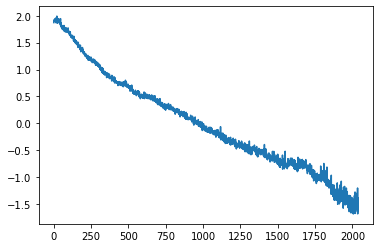

In [34]:
plt.plot(optim._loss_history)

In [51]:

optim = OptimSPSA(theta_0, partial(get_loss_from_theta, perc=1.0), max_delta_theta=0.1, max_iter=1000, c0=100)
optim.calibrate()

After calibration:  {'gamma': 0.101, 'alpha': 0.602, 'max_delta_theta': 0.1, 'max_iter': 1000, 'c0': 0.001, 'A': 130.0, 'a0': 1.7894715150760794}


In [52]:
theta = optim.run()
theta

1: 1.9267007027741025
101: 0.375727682649743
201: 0.0395798856700178
301: -0.5199291895064843
401: -0.3003998504535863
501: -0.4235301155058031
601: -0.4274440148269396
701: -1.0814995716005074
801: -0.9856972648717988
901: -0.5303810628270716


array([1.1423998 , 1.22452225, 6.01833278])

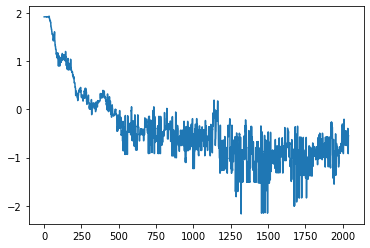

In [53]:
plt.plot(optim._loss_history)

After calibration:  {'gamma': 0.101, 'alpha': 1.2, 'max_delta_theta': 0.1, 'max_iter': 1000, 'c0': 0.001, 'A': 130.0, 'a0': 14.972016809349043}
1: 1.9147391142189303
101: 0.5945014240189785
201: 0.0716070384850438
301: -0.5730911952611696
401: -0.7667344667547644
501: -0.5120694645234005
601: -0.8707767914701979
701: -0.761005907889035
801: -1.3016825629559832
901: -1.1428381991445338


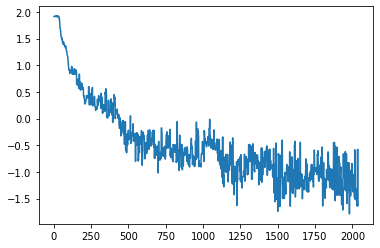

In [54]:

optim = OptimSPSA(theta_0, partial(get_loss_from_theta, perc=1.0), max_delta_theta=0.1, alpha=1.2, max_iter=1000, c0=100)
optim.calibrate()
theta = optim.run()
plt.plot(optim._loss_history)

After calibration:  {'gamma': 0.101, 'alpha': 1.2, 't0': 0.05, 'max_delta_theta': 0.1, 'max_iter': 1000, 'c0': 0.00031622776601683794, 'A': 130.0, 'a0': 9.82923326498195}
1: 1.9267007027741025
101: 0.49687596425727903
201: 0.33280688708012185
301: -0.25285934601861315
401: -0.15795362304495075
501: -0.13361750672575967
601: -0.05428603965189294
701: -0.5780154377632731
801: -0.8312433569552922
901: -1.3409980862047144


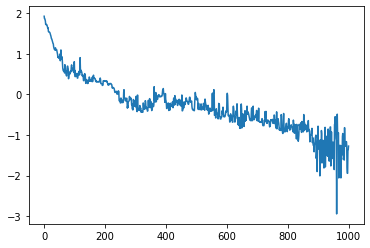

In [59]:

optim = OptimSPSA(theta_0, partial(get_loss_from_theta, perc=1.0), max_delta_theta=0.1, alpha=1.2, max_iter=1000, c0=100, t0=0.05)
optim.calibrate()
theta = optim.run()
plt.plot(optim._loss_history)

After calibration:  {'gamma': 0.25, 'alpha': 1.2, 'max_delta_theta': 0.1, 'max_iter': 1000, 'c0': 0.001, 'A': 130.0, 'a0': 29.167927154029027}
1: 1.9267007027741025
101: 0.14113869531667012
201: -0.24874852432899375
301: -0.49271021187226005
401: -0.3300604359800092
501: -0.5093472587955362
601: -1.1720886486107187
701: -0.3902069542957922
801: -0.8965715134216359
901: -0.879108907117219


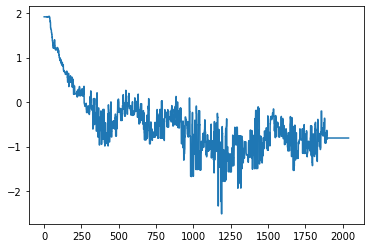

In [55]:

optim = OptimSPSA(theta_0, partial(get_loss_from_theta, perc=1.0), max_delta_theta=0.1, alpha=1.2, gamma=0.25, max_iter=1000, c0=100)
optim.calibrate()
theta = optim.run()
plt.plot(optim._loss_history)

In [30]:
optim.ck(optim.k)

0.010116986155810597

In [ ]:
M = trimesh.transformations.affine_matrix_from_points([[0, 1031, 1031, 0], [0, 0, 1600, 1600]], [[675, 826, 826, 677], [55, 52, 281, 277]], scale=False, shear=False)
M

array([[ 9.99997787e-01,  2.10398215e-03,  2.33817955e+02],
       [-2.10398215e-03,  9.99997787e-01, -6.32663627e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [ ]:
T = translation_matrix(np.random.random(3)-0.5)
R = random_rotation_matrix(np.random.random(3))
S = scale_matrix(random.random())
M2 = trimesh.transformations.concatenate_matrices(T, R, S)

array([[ 9.99997787e-01,  2.10398215e-03,  2.33817955e+02],
       [-2.10398215e-03,  9.99997787e-01, -6.32663627e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [ ]:
trimesh.transformations.random_rotation_matrix(np.array([0, 0, 0]))

array([[-1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  1.]])

I get the oriented bounding boxes between the two images, and I compute the affine projection to align them



In [ ]:
np.eye(4)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [ ]:
def transformation_matrix_from_affine(affine_matrix):
    # add a row between... 
    transformation_matrix = np.eye(4)
    transformation_matrix[:2, :2] = affine_matrix[:2, :2]
    transformation_matrix[:2, 3] = affine_matrix[:2, 2]
    return transformation_matrix

transformation_matrix_from_affine(M)
    

array([[ 9.99997787e-01,  2.10398215e-03,  0.00000000e+00,
         2.33817955e+02],
       [-2.10398215e-03,  9.99997787e-01,  0.00000000e+00,
        -6.32663627e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [ ]:
M

array([[ 9.99997787e-01,  2.10398215e-03,  2.33817955e+02],
       [-2.10398215e-03,  9.99997787e-01, -6.32663627e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [ ]:
inds = pixels[np.random.choice(640*480, 100, replace=False)]
inds

array([[559, 293],
       [386, 464],
       [517, 117],
       [ 50, 410],
       [  0, 363],
       [542, 476],
       [118,  89],
       [399,  64],
       [ 13, 348],
       [338, 272],
       [299, 310],
       [176, 475],
       [632, 224],
       [ 69, 196],
       [259, 321],
       [ 63,  98],
       [436,   0],
       [107, 129],
       [309,  84],
       [625,  19],
       [470, 222],
       [458, 469],
       [574, 220],
       [ 35,  33],
       [300, 203],
       [ 27, 322],
       [130,  14],
       [313, 427],
       [202, 283],
       [179, 275],
       [303, 469],
       [468, 187],
       [171, 349],
       [408,  89],
       [398,   9],
       [483, 109],
       [614, 100],
       [609, 448],
       [565, 103],
       [471, 256],
       [284, 343],
       [405,  13],
       [409, 479],
       [425, 437],
       [463, 225],
       [277, 194],
       [104, 224],
       [229,  25],
       [434, 232],
       [617, 250],
       [533, 216],
       [ 94, 178],
       [291,

In [ ]:
trimesh.bounds.oriented_bounds_2D(inds)

(array([[ 9.99954652e-01,  9.52337763e-03, -3.18780781e+02],
        [-9.52337763e-03,  9.99954652e-01, -2.35203619e+02],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([630.64759033, 479.75919509]))

So we first align the image in 3d space, finding translation... 

We can approximate 3d rotation...

We can work on a bounding box for translation, then we can do rotation